In [0]:
from google.colab import drive
drive.mount('drive')
# %cd /gdrive

# Imports

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
from PIL import Image

In [0]:
parent_dir = "drive/My Drive/MSDS_DL/assignment_5b/"
data_dir = parent_dir + "data/A_05_Part_02_Dataset/"
weights_dir = parent_dir + "weights/"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Find Mean and std of train,valid and test

In [0]:
train_dirs = os.listdir(data_dir+'Train/')
train_imgs = []
for d in train_dirs:
  files = os.listdir(data_dir+"Train/"+d)
  for f in files:
    if f.endswith('.png') or f.endswith('.jpg'):
      img = Image.open(data_dir+"Train/"+d+"/"+f)
      img = img.resize(size=(256,256), resample=Image.LANCZOS)
      img = np.array(img)
      train_imgs.append(img)
len(train_imgs)

In [0]:
valid_dirs = os.listdir(data_dir+'Validation/')
valid_imgs = []
for d in valid_dirs:
  files = os.listdir(data_dir+"Validation/"+d)
  for f in files:
    if f.endswith('.png') or f.endswith('.jpg'):
      img = Image.open(data_dir+"Validation/"+d+"/"+f)
      img = img.resize(size=(256,256), resample=Image.LANCZOS)
      img = np.array(img)
      valid_imgs.append(img)
len(valid_imgs)

623

In [0]:
test_files = os.listdir(data_dir+'Test/test')
test_imgs = []
test_img_labels =  []
for f in test_files:
  if f.endswith('.png') or f.endswith('.jpg'):
    img = Image.open(data_dir+"Test/test/"+f)
    img = img.resize(size=(256,256), resample=Image.LANCZOS)
    img = np.array(img)
    test_imgs.append(img)
    test_img_labels.append(f)

In [24]:
len(test_img_labels)

629

In [0]:
count = 1
for i,img in enumerate(train_imgs):
  if img.ndim >2:
    print(f"{count}: {i} image has {img.ndim} and shape {img.shape}")
    count +=1
    train_imgs[i] = img[:,:,0]

In [0]:
count = 1
for i,img in enumerate(valid_imgs):
  if img.ndim >2:
    print(f"{count}: {i} image has {img.ndim} and shape {img.shape}")
    count +=1
    valid_imgs[i] = img[:,:,0]

In [25]:
count = 1
for i,img in enumerate(test_imgs):
  if img.ndim >2:
    print(f"{count}: {i} image has {img.ndim} and shape {img.shape}")
    count +=1
    test_imgs[i] = img[:,:,0]

  test_imgs[i] = np.stack((test_imgs[i],)*3,axis=0)


1: 0 image has 3 and shape (256, 256, 3)
2: 1 image has 3 and shape (256, 256, 3)
3: 2 image has 3 and shape (256, 256, 3)
4: 3 image has 3 and shape (256, 256, 3)
5: 4 image has 3 and shape (256, 256, 3)
6: 5 image has 3 and shape (256, 256, 3)
7: 6 image has 3 and shape (256, 256, 3)
8: 7 image has 3 and shape (256, 256, 3)
9: 8 image has 3 and shape (256, 256, 4)
10: 9 image has 3 and shape (256, 256, 3)
11: 11 image has 3 and shape (256, 256, 3)
12: 12 image has 3 and shape (256, 256, 3)
13: 13 image has 3 and shape (256, 256, 3)
14: 14 image has 3 and shape (256, 256, 3)
15: 15 image has 3 and shape (256, 256, 3)
16: 16 image has 3 and shape (256, 256, 4)
17: 17 image has 3 and shape (256, 256, 3)
18: 18 image has 3 and shape (256, 256, 3)
19: 19 image has 3 and shape (256, 256, 3)
20: 20 image has 3 and shape (256, 256, 3)
21: 21 image has 3 and shape (256, 256, 3)
22: 22 image has 3 and shape (256, 256, 3)
23: 23 image has 3 and shape (256, 256, 3)
24: 24 image has 3 and shape (

In [0]:
train_mean = np.mean(train_imgs)
train_std = np.std(train_imgs)
print(f"Train mean {train_mean} train_std {train_std}")

valid_mean = np.mean(valid_imgs)
valid_std = np.std(valid_imgs)
print(f"Train mean {valid_mean} train_std {valid_std}")

test_mean = np.mean(test_imgs)
test_std = np.std(test_imgs)
print(f"test mean {test_mean} test_std {test_std}")

Train mean 125.38420718934697 train_std 63.397660193282846
Train mean 125.60233139111563 train_std 63.88390271414833
test mean 125.95635117862865 test_std 64.98013607359859


In [0]:
print(f"Train mean {train_mean/255} train_std {train_std/255}")
print(f"Valid mean {valid_mean/255} valid_std {valid_std/255}")
print(f"test mean {test_mean/255} test_std {test_std/255}")

Train mean 0.4917027732915567 train_std 0.24861827526777586
Train mean 0.4925581623181005 train_std 0.2505251086829346
test mean 0.49394647521030843 test_std 0.25482406303371996


# Input Pipeline

In [0]:
class int_to_multilabel(object):
  """convert int to multilabel one hot vector"""
  def __init__(self,no_of_classes=3,multilabel={0:[0,2]}):
    self.no_of_classes = no_of_classes
    self.multilabel = multilabel

  def __call__(self,label_int):
    output = torch.zeros(self.no_of_classes)

    assert label_int < self.no_of_classes, "input int_label should be less than no. of classes"
    output[label_int] = 1

    for K,V in self.multilabel.items():
      if label_int == K:
        output[V] = 1
        break 
    return output

In [0]:
train_transform = transforms.Compose(
                        [transforms.Resize(size = (256,256), interpolation=Image.LANCZOS),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomRotation(30),
                        # transforms.RandomResizedCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize([0.4917], [0.2486])])

valid_transform = transforms.Compose(
                        [transforms.Resize(size = (256,256), interpolation=Image.LANCZOS),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomRotation(30),
                        # transforms.RandomResizedCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize([0.4926], [0.2505])])

test_transform = transforms.Compose(
                        [transforms.Resize(size = (256,256), interpolation=Image.LANCZOS),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomRotation(30),
                        # transforms.RandomResizedCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize([0.4940], [0.2548])])

In [0]:
train_data = datasets.ImageFolder(root = data_dir+'Train',transform = train_transform,target_transform = int_to_multilabel())
valid_data = datasets.ImageFolder(root = data_dir+'Validation',transform = train_transform,target_transform = int_to_multilabel())
test_data = datasets.ImageFolder(root = data_dir+'Test',transform = test_transform)

# Data Loaders

In [11]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True,num_workers=4)
# trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True,num_workers=4)
# validloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=150, shuffle=True,num_workers=4)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid', 'normal', 'pneumonia']


# Helper Functions

In [0]:
from sklearn.metrics import f1_score,accuracy_score
from sklearn.metrics import confusion_matrix,multilabel_confusion_matrix

def plot_confusion_matrix(confusion,classes=None, title='Confusion matrix', cmap=plt.cm.gray_r):
    ##X-axis is predicted and y_asix is true
    import seaborn as sn
    import pandas as pd
    import matplotlib.pyplot as plt
    if classes is not None:
      df_cm = pd.DataFrame(confusion, classes, classes)
    else :
      df_cm = pd.DataFrame(confusion, range(len(confusion)), range(len(confusion)))
    # plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.title(title)

    plt.savefig("confusion_matrix")
    plt.show()

def evaluate(model,loss_function,data_loader,device):
  model.eval()
  loss = 0
  accuracy = 0

  with torch.no_grad():
    for i,data in enumerate(data_loader):
      inputs,labels = data
      N,C = labels.shape
      inputs,labels = inputs.to(device),labels.to(device)
      outputs = model(inputs)
      loss += loss_function(outputs,labels).item()
      outputs[outputs >= 0.5] = 1
      outputs[outputs < 0.5] = 0
      accuracy += (outputs == labels).sum().item()/(N*C)*100
  return loss/len(data_loader),accuracy/len(data_loader)

def calc_accuracy(prediction,target):
  N,C = target.shape
  accuracy = (prediction == target).sum()/(N*C) * 100
  return accuracy

def predict(model,data_loader,device):
  model.to(device)
  # sigmoid_function = nn.Sigmoid()
  model.eval()
  num_elements = len(data_loader.dataset)
  predictions = torch.zeros((num_elements,3))
  all_labels = torch.zeros((num_elements,3))
  num_batches = len(data_loader)
  batch_size = data_loader.batch_size

  with torch.no_grad():
    for i,data in enumerate(data_loader):
      start = i*batch_size
      end = start + batch_size
      if i == num_batches - 1:
          end = num_elements

      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)
      outputs = model(inputs)
      # outputs = sigmoid_function(outputs)
      # _, pred = torch.max(outputs.data, 1)
      outputs[outputs >= 0.5] =1
      outputs[outputs < 0.5] = 0
      # _, predicted = torch.max(outputs.data, 1)
      predictions[start:end] = outputs
      all_labels[start:end] = labels
  return all_labels.cpu().data.numpy(),predictions.cpu().data.numpy()

def calc_f1_score(prediction,target):
  p = np.logical_and(prediction == target, prediction == 1).sum() / prediction.sum() * 100
  r = np.logical_and(prediction == target, prediction == 1).sum().sum() / target.sum() * 100

  f1 = (2 * p * r)/ (p+r)
  return f1

# Custom BCE Loss

In [0]:
def multilabel_BCELoss(prediction,label):
  """prediction are probabilities"""
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  prob_power = prediction ** label
  exp50 = torch.ones(label.shape) * torch.exp(torch.tensor([50],dtype=torch.float32))
  exp50 = exp50.to(device) 
  prob = torch.where(prob_power == 0,exp50,prob_power) # replacing 0 with exp(50) for numerical stability
  log_prob = - torch.log(prob)
  alpha = torch.tensor([1,0.05,0.1]).to(device) #weights covid, normal, pneumonia
  log_prob = log_prob * alpha
  loss = torch.sum(log_prob,axis=1)
  return torch.mean(loss)

# focal loss

In [0]:
def focal_loss(prediction,label,is_alpha_balanced = True):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  gamma = torch.tensor([2]).to(device)
  alpha = torch.tensor([1,0.05,0.1]).to(device) #weights covid, normal, pneumonia

  prob_power = prediction ** label
  exp50 = torch.ones(label.shape) * torch.exp(torch.tensor([50],dtype=torch.float32))
  exp50 = exp50.to(device) 
  prob = torch.where(prob_power == 0,exp50,prob_power) # replacing 0 with exp(50) for numerical stability
  one_minus_prob = torch.ones_like(prob).to(device)
  one_minus_prob = one_minus_prob - prob
  log_prob = - torch.log(prob)
  if is_alpha_balanced:
    loss = alpha * (one_minus_prob ** gamma) * log_prob
  else:
    loss = (one_minus_prob ** gamma) * log_prob
  loss = torch.sum(loss,axis=1)
  return torch.mean(loss)


In [0]:
bce_loss = nn.BCELoss(reduction='none')
def focal_loss_predefined(prediction,label):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  gamma = torch.tensor([2]).to(device)
  alpha = torch.tensor([1,0.05,0.1]).to(device) #weights covid, normal, pneumonia
 # replacing 0 with exp(50) for numerical stability
  BC_Loss = bce_loss(prediction,label)
  prob = torch.exp(-BC_Loss)
  one_minus_prob = torch.ones_like(prob).to(device)
  one_minus_prob = one_minus_prob - prob
  # log_prob = - torch.log(prob)
  
  loss = alpha * (one_minus_prob ** gamma) * BC_Loss

  loss = torch.sum(loss,axis=1)
  return torch.mean(loss)

# Train function

In [0]:
def train(model,train_loader,opt,loss_function,epochs,valid_loader=None, weight_save_path = None,batch_info=True,dot_after_batch=5,asterik_after_batch=20):
  # from tqdm import tqdm
  import time
  #if you have gpu then you need to convert the network and data to cuda
  #the easiest way is to first check for device and then convert network and data to device
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  
  model.to(device)
  
  epoch_loss_list = []
  epoch_accuracy_list = []
  valid_loss_list = []
  valid_accuracy_list = []

  for epoch in range(epochs):  # loop over the dataset multiple times
      tic = time.time()
      model.train()
      running_loss = 0.0
      running_accuracy = 0.0
      # pbar = tqdm(enumerate(train_loader))
      # for i, data in pbar:
      for i, data in enumerate(train_loader):
          # get the inputs
          # with torch.autograd.set_detect_anomaly(True):

          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          
          opt.zero_grad()
          # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
          # because PyTorch accumulates the gradients on subsequent backward passes. 
          # This is convenient while training RNNs. 
          # So, the default action is to accumulate the gradients on every loss.backward() call

          # forward + backward + optimize
          outputs = model(inputs)               #----> forward pass
          # print(outputs)
          loss = loss_function(outputs, labels)   #----> compute loss
          # loss = multilabel_BCELoss(outputs,labels)
          # print(f"Loss sahpe is {loss.shape}")
          # print(f"loss is {loss}")
          loss.backward()                     #----> backward pass
          opt.step()                    #----> weights update

          # print statistics
          running_loss += loss.item()
          N,C = labels.shape
          # print(f"output before thresholding")
          # print(outputs)
          outputs[outputs >= 0.5] = 1
          # print(f"output after 1 thresholding")
          # print(outputs)
          outputs[outputs < 0.5] = 0
          # print(f"output after 0 thresholding")
          # print(outputs)
          running_accuracy += (outputs == labels).sum().item()/(N*C) *100

          # pbar.set_description(f"Train Epoch: {epoch} [{i * len(inputs)}/{len(train_loader.dataset)}\
          #                     {100. * i / len(train_loader):.0f}%)]\tLoss: {loss.item():.4f}\taccuracy:{correct/total:.3f}")
          if batch_info:
            if (i+1) % asterik_after_batch == 0:
              print("*",end=' ')
            elif (i+1) % dot_after_batch == 0:
              print(".",end=' ')
      print()
      epoch_loss_list.append(running_loss / len(train_loader))
      epoch_accuracy_list.append(running_accuracy/len(train_loader))

      if valid_loader is not None:
        valid_loss,valid_acc = evaluate(model,loss_function,valid_loader,device)
        valid_loss_list.append(valid_loss)
        valid_accuracy_list.append(valid_acc)
        toc = time.time()
        print(f"Epoch: {epoch} train_loss:{running_loss / len(train_loader):.4f}   train_acc:{running_accuracy/len(train_loader):.3f}   valid_loss:{valid_loss:.4f}   valid_acc:{valid_acc:.3f} time-taken:{(toc-tic)/60:.3f}m")
      else:

        print(f"Epoch: {epoch} train_loss:{running_loss / len(train_loader):.4f}   train_acc:{running_accuracy/len(train_loader):.3f}")
      if weight_save_path is not None:
        torch.save(model.state_dict(), weight_save_path)

  print('Finished Training')
  if valid_loader is not None:
    return epoch_loss_list,epoch_accuracy_list,valid_loss_list,valid_accuracy_list
  else:
    return epoch_loss_list,epoch_accuracy_list

# Vgg

In [111]:
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [0]:
vgg16_classifier = nn.Sequential(nn.Linear(25088,300),
                            nn.ReLU(),
                            nn.Dropout(p=0.5),
                            nn.Linear(300,80),
                            nn.ReLU(),
                            nn.Dropout(p=0.5),
                            nn.Linear(80,3)
                            # nn.Sigmoid()
                            )
vgg16.classifier = vgg16_classifier

In [0]:
vgg_optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()
custom_focal_loss = focal_loss_predefined

## Train

In [0]:
vgg_train_loss, vgg_train_acc, vgg_valid_loss, vgg_valid_acc = train(vgg16,trainloader,vgg_optimizer,criterion,20,validloader,weights_dir+"vgg16_focal_loss.pth",
                                                  batch_info=False,dot_after_batch=5,asterik_after_batch=10)

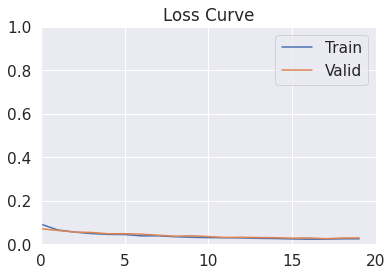

In [0]:
plt.plot(vgg_train_loss,label = 'Train')
plt.plot(vgg_valid_loss,label = 'Valid')
plt.xlim([0,20])
plt.ylim([0,1])
plt.title("Loss Curve")
plt.legend()
plt.show()

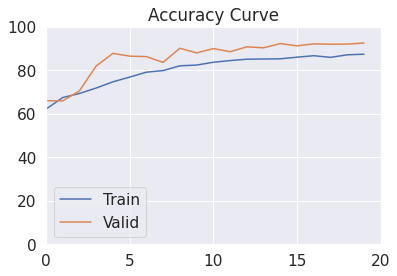

In [0]:
plt.plot(vgg_train_acc,label = 'Train')
plt.plot(vgg_valid_acc,label = 'Valid')
plt.xlim([0,20])
plt.ylim([0,100])
plt.title("Accuracy Curve")
plt.legend()
plt.show()

# accuracy,f1 score and confusion matrix

Train accuracy 92.48387096774194
Train f1 score 89.2742059229707


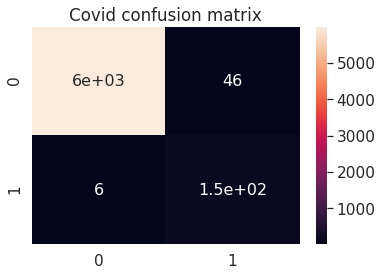

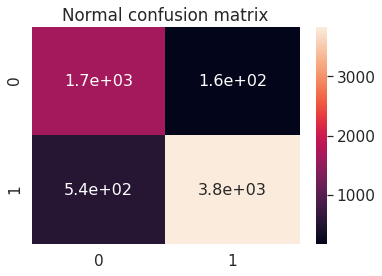

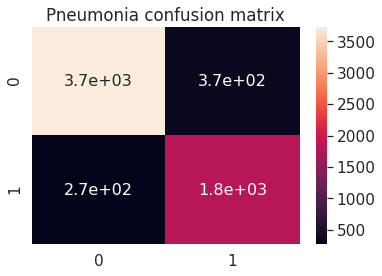

In [0]:
train_labels,train_prediction = predict(vgg16,trainloader,device)
train_accuracy = calc_accuracy(train_prediction,train_labels)
train_f1 = calc_f1_score(train_prediction,train_labels)
train_confusion = multilabel_confusion_matrix(train_prediction,train_labels)
print(f"Train accuracy {train_accuracy}")
print(f"Train f1 score {train_f1}")
plot_confusion_matrix(train_confusion[0],title = 'Covid confusion matrix')
plot_confusion_matrix(train_confusion[1],title = 'Normal confusion matrix')
plot_confusion_matrix(train_confusion[2],title = 'Pneumonia confusion matrix')

valid accuracy 92.67515923566879
valid f1 score 89.63963963963964


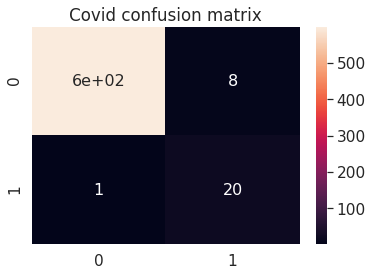

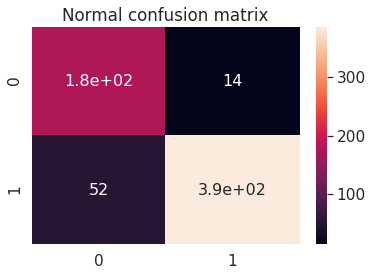

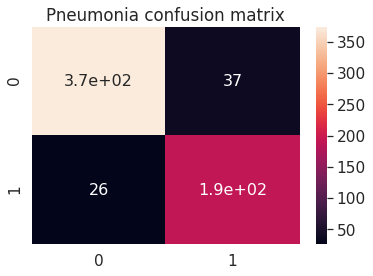

In [0]:
valid_labels,valid_prediction = predict(vgg16,validloader,device)
valid_accuracy = calc_accuracy(valid_prediction,valid_labels)
valid_f1 = calc_f1_score(valid_prediction,valid_labels)
valid_confusion = multilabel_confusion_matrix(valid_prediction,valid_labels)
print(f"valid accuracy {valid_accuracy}")
print(f"valid f1 score {valid_f1}")
plot_confusion_matrix(valid_confusion[0],title = 'Covid confusion matrix')
plot_confusion_matrix(valid_confusion[1],title = 'Normal confusion matrix')
plot_confusion_matrix(valid_confusion[2],title = 'Pneumonia confusion matrix')

# Resnet

In [0]:
resnet18 = models.resnet18(pretrained=True)


In [0]:
resnet18_fc = nn.Sequential(nn.Linear(512,200),
                            nn.ReLU(),
                            nn.Dropout(p=0.5),
                            nn.Linear(200,50),
                            nn.ReLU(),
                            nn.Dropout(p=0.5),
                            # nn.Linear(1024,512),
                            # nn.ReLU(),
                            # nn.Dropout(p=0.5),
                            nn.Linear(50,3),
                            nn.Sigmoid()
                            )
resnet18.fc = resnet18_fc

In [0]:
resnet_optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()
custom_alpha_balanced_loss = focal_loss
custom_alpha_balanced_loss_pre = focal_loss_predefined

## Train

In [34]:
resnet_train_loss, resnet_train_acc, resnet_valid_loss, resnet_valid_acc = train(resnet18,trainloader,resnet_optimizer,custom_alpha_balanced_loss_pre,20,validloader,
                                                                                  weight_save_path=weights_dir+"res18_focal_loss.pth’",
                                                  batch_info=False,dot_after_batch=5,asterik_after_batch=10)

# resnet_train_loss, resnet_train_acc, resnet_valid_loss, resnet_valid_acc = train(resnet18,trainloader,resnet_optimizer,custom_alpha_balanced_loss,20,validloader,
#                                                                                  weights_dir+"resnet_custom_alpha_balanced_focal_loss.pth",
#                                                   batch_info=False,dot_after_batch=5,asterik_after_batch=10)
# vgg_train_loss, vgg_train_acc, vgg_valid_loss, vgg_valid_acc = train(vgg16,validloader,vgg_optimizer,criterion,10,valid_loader = None, weight_save_path=None ,
#                                                   batch_info=False,dot_after_batch=5,asterik_after_batch=10)


Epoch: 0 train_loss:0.0975   train_acc:70.557   valid_loss:0.0536   valid_acc:74.515 time-taken:1.341m

Epoch: 1 train_loss:0.0543   train_acc:74.116   valid_loss:0.0507   valid_acc:74.535 time-taken:1.336m

Epoch: 2 train_loss:0.0489   train_acc:75.509   valid_loss:0.0467   valid_acc:74.900 time-taken:1.329m

Epoch: 3 train_loss:0.0463   train_acc:77.317   valid_loss:0.0450   valid_acc:75.773 time-taken:1.325m

Epoch: 4 train_loss:0.0439   train_acc:78.690   valid_loss:0.0420   valid_acc:78.666 time-taken:1.325m

Epoch: 5 train_loss:0.0400   train_acc:80.837   valid_loss:0.0415   valid_acc:82.845 time-taken:1.333m

Epoch: 6 train_loss:0.0386   train_acc:81.419   valid_loss:0.0370   valid_acc:88.654 time-taken:1.320m

Epoch: 7 train_loss:0.0381   train_acc:83.099   valid_loss:0.0390   valid_acc:89.792 time-taken:1.323m

Epoch: 8 train_loss:0.0361   train_acc:84.093   valid_loss:0.0365   valid_acc:90.869 time-taken:1.322m

Epoch: 9 train_loss:0.0352   train_acc:85.437   valid_loss:0.03

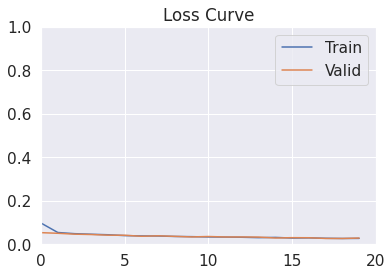

In [35]:
plt.plot(resnet_train_loss,label = 'Train')
plt.plot(resnet_valid_loss,label = 'Valid')
plt.xlim([0,20])
plt.ylim([0,1])
plt.title("Loss Curve")
plt.legend()
plt.show()

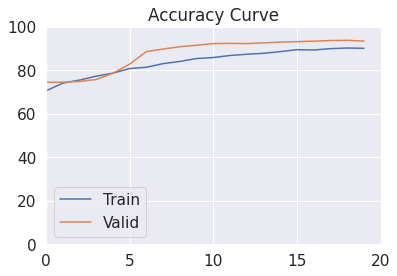

In [36]:
plt.plot(resnet_train_acc,label = 'Train')
plt.plot(resnet_valid_acc,label = 'Valid')
plt.xlim([0,20])
plt.ylim([0,100])
plt.title("Accuracy Curve")
plt.legend()
plt.show()

# Accuracy, F1 and confusion

Train accuracy 93.7741935483871
Train f1 score 90.82117945466076


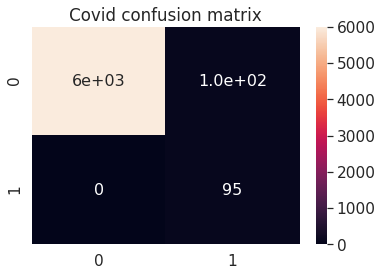

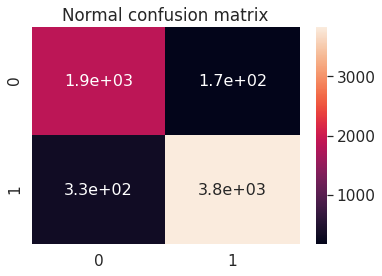

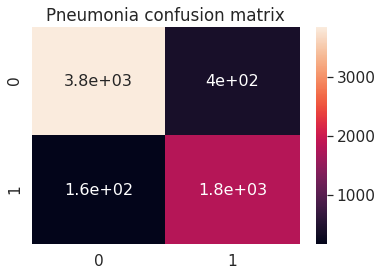

In [42]:
train_labels,train_prediction = predict(resnet18,trainloader,device)
train_accuracy = calc_accuracy(train_prediction,train_labels)
train_f1 = calc_f1_score(train_prediction,train_labels)
train_confusion = multilabel_confusion_matrix(train_prediction,train_labels)
print(f"Train accuracy {train_accuracy}")
print(f"Train f1 score {train_f1}")
plot_confusion_matrix(train_confusion[0],title = 'Covid confusion matrix')
plot_confusion_matrix(train_confusion[1],title = 'Normal confusion matrix')
plot_confusion_matrix(train_confusion[2],title = 'Pneumonia confusion matrix')

valid accuracy 93.78980891719745
valid f1 score 90.92319627618309


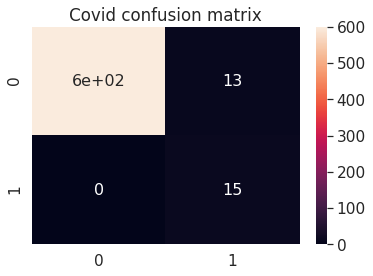

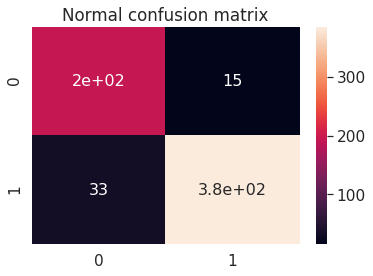

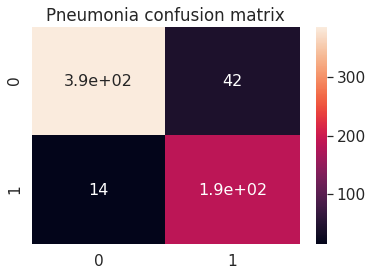

In [44]:
valid_labels,valid_prediction = predict(resnet18,validloader,device)
valid_accuracy = calc_accuracy(valid_prediction,valid_labels)
valid_f1 = calc_f1_score(valid_prediction,valid_labels)
valid_confusion = multilabel_confusion_matrix(valid_prediction,valid_labels)
print(f"valid accuracy {valid_accuracy}")
print(f"valid f1 score {valid_f1}")
plot_confusion_matrix(valid_confusion[0],title = 'Covid confusion matrix')
plot_confusion_matrix(valid_confusion[1],title = 'Normal confusion matrix')
plot_confusion_matrix(valid_confusion[2],title = 'Pneumonia confusion matrix')

# Predict test samples

In [0]:
vgg16 = models.vgg16(pretrained=True)
# print(vgg16)
vgg16_classifier = nn.Sequential(nn.Linear(25088,300),
                            nn.ReLU(),
                            nn.Dropout(p=0.5),
                            nn.Linear(300,80),
                            nn.ReLU(),
                            nn.Dropout(p=0.5),
                            nn.Linear(80,3)
                            # nn.Sigmoid()
                            )
vgg16.classifier = vgg16_classifier


In [76]:
vgg16.load_state_dict(torch.load(weights_dir+"vgg16_custom_focal_loss_alpha_balanced_300_80_after_20.pth"))

<All keys matched successfully>

In [0]:
np_test_imgs = np.array(test_imgs)
# test_img_labels 
np_test_imgs = np_test_imgs/255
np_test_imgs = (np_test_imgs- 0.494)/0.2548

In [77]:
model_predictions = np.zeros((629,3))
batch_size = 64
batch_start_idx = np.arange(0,629,batch_size)
vgg16.to(device)
vgg16.eval()
with torch.no_grad():
  for i,start_idx in enumerate(batch_start_idx):
    if i == len(batch_start_idx)-1:
      end_idx = 628
    else:
      end_idx = start_idx + batch_size
    
    imgs = np_test_imgs[start_idx:end_idx]
    print(imgs.shape)
    imgs = torch.tensor(imgs).float().to(device)
    
    outputs = vgg16(imgs)
    outputs[outputs >= 0.5 ] =1
    outputs[outputs < 0.5 ] =0
    model_predictions[start_idx:end_idx] = outputs.cpu().data.numpy()

(64, 3, 256, 256)
(64, 3, 256, 256)
(64, 3, 256, 256)
(64, 3, 256, 256)
(64, 3, 256, 256)
(64, 3, 256, 256)
(64, 3, 256, 256)
(64, 3, 256, 256)
(64, 3, 256, 256)
(52, 3, 256, 256)


In [0]:
for i,p in enumerate(model_predictions):
  print(f"{i}:{p}")


In [0]:
import csv
filename = "Results.csv"
with open(filename, 'w') as csvfile:  
    
    csvwriter = csv.writer(csvfile)  
    for i,name in enumerate(test_img_labels):

     
      csvwriter.writerow([name,model_predictions[i][0],model_predictions[i][2],model_predictions[i][1]])  
        